In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP_jitter, make_FP_axs
# from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir
from tools_lnd import comp_eig_decomp, make_h_all, take_names, plot_N

In [2]:
model_n = 1
task_list = ['fdgo','fdanti','delaygo','delayanti']
task_list = ['dmcgo','dmcnogo']
rule = task_list[0]
which_net = 'l2h00001'
fldr = 'all_tasks'
supp = []#'long_train'

if fldr == '4_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
else:
    file_spec = which_net
    
dir_specific_all = os.path.join('crystals','softplus',file_spec)#,supp)
    
m = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
# h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','figure3')
if not os.path.exists(figpath):
    os.makedirs(figpath)

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


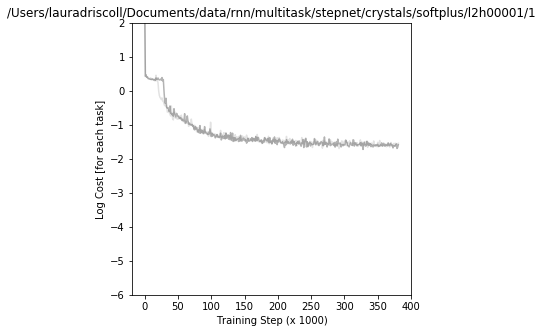

In [3]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [4]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/1/model.ckpt


In [26]:
rule = 'fdanti'
e_name = 'stim1'
trial = generate_trials(rule, hparams, 'test', noise_on=False)
h_all_byepoch, h_all_byrule = make_h_all(m)
X_rule = h_all_byrule[rule]

X_use = X_rule

from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
fp_pca = pca.fit_transform(np.reshape(X_use[:],(-1,hparams['n_rnn'])))
D_use = pca.components_.T

Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

NameError: name 'plot_FP_jitter_2D' is not defined

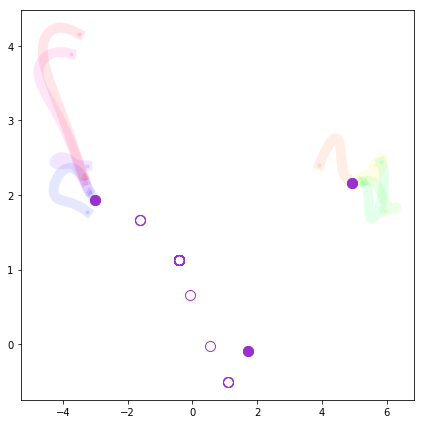

In [21]:
########## X STIM ###########
from itertools import compress 

fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
t_set = [90,118.8]
fp_t_set = [18,18]
trial_num = [20,28]
n_interp = 20
n_fps_init = 60
n_fps = 60
trial_set = range(0,80,10)
task_list = ['dmcgo',]
rule_set = [task_list[0],]
epoch_set = ['delay1',]
step_file = 'interp_stim'
axs = 'tdr'
linestyle = ['-','--']

ei = 0
epoch = epoch_set[ei]
ri = 0
rule = rule_set[ei]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)

stim_axs = 0
f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(fp_t_set[stim_axs])+'.0.npz')
D_use,_,_ = make_FP_axs(f,m,rule,epoch,axs =axs, clust = 'False')
epoch_name, rule_name, _, _ = take_names(epoch,rule)
axes_label1 =  epoch_name +' '+ axs + ' 1'
axes_label2 = epoch_name +' '+ axs + ' 2'

# use_yinds = [2,4]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]

# D_use = Beta_qr[:,use_yinds]
# D_use[:,1] = w_out[:,2]
# axes_label2 = 'sin out'

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['darkorchid','orange']

_,x = gen_X_from_model_dir(m,trial)
T_inds = get_T_inds(trial,epoch_set[0])
x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
       linestyle = linestyle[ri], alpha = .1)
    
for si in range(len(t_set)):
    ax = plt.subplot(111)
    
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(fp_t_set[si])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)
#     print(np.log10(qvals))
    
    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
    stable_fps = [np.max(eig_decomps[fp_ind]['evals'])<1 for fp_ind in range(len(eig_decomps))]
    stable_fps_arg = list(compress(range(len(stable_fps)), stable_fps)) 

    plt.plot(fp_project[:,0],fp_project[:,1],'o',c = cmap_discrete[si],
             markersize = 10, markerfacecolor = 'none', alpha = 1,linewidth = 5)
    plt.plot(fp_project[stable_fps_arg,0],fp_project[stable_fps_arg,1],'o',c = cmap_discrete[si],
             markersize = 10, alpha = 1,linewidth = 5)
    
#     _,x = gen_X_from_model_dir(m,trial)
#     T_inds = get_T_inds(trial,epoch)
#     x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

#     X_trial = np.dot(x_epoch[trial_set[si],:,:],D_use)
#     plt.plot(X_trial[:,0],X_trial[:,1],c = cmap_discrete[si],linewidth = 2, 
#            linestyle = linestyle[ri], alpha = 1)
    
    plot_FP_jitter_2D(m,D_use,rule,trial_num[si],epoch,sorted_fps,range(len(sorted_fps)),qvals,
                      rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 50,
                      n_jit = 1,unstable_qlim = -10,c = cmap_discrete[si])

    for step_i in range(n_interp):
        
        f = rule+'_'+epoch+'_'+str(t_set[0])+'_'+str(t_set[1])+'_step_'+str(step_i)
        filename = os.path.join(m,step_file,rule,f+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']

        fp_project = np.dot(step_fps,D_use)
        plt.plot(fp_project[:,0],fp_project[:,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp))
        
tit = rule_name+ ' X STIM'
plt.title(tit,fontsize = 18)
plt.xlabel(axes_label1,fontsize = 18)
plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+str(t_set[1])+'_'+tit+'.pdf'
plt.savefig(os.path.join(figpath,step_file,figname),dpi = 30)
figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+str(t_set[1])+'_'+tit+'.png'
plt.savefig(os.path.join(figpath,step_file,figname),dpi = 30)
plt.show()

In [12]:
trial_str = '_'.join(str(t) for t in [18.0,18.0])

In [13]:
trial_str

'18.0_18.0'

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2h00001/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multit

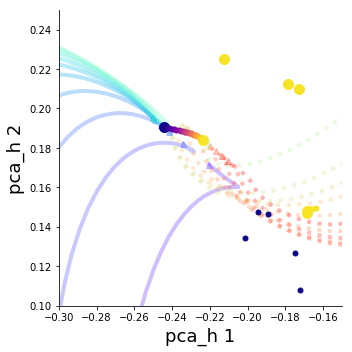

In [37]:
########## X TASK ###########

fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
n_interp = 20

for offset in [18,]:

    t_set = [(offset)%360, (offset+180)%360]
    trial_num = [0,0]#[int(offset/4), int(offset/4)]


    trial_set = range(0,80,4)
    rule_set = ['dmcgo','dmcnogo']
    epoch_set = ['delay1','delay1']
    step_file = 'interp_tasks'
    linestyle = ['-',':']
    axs = 'pca_h'

    trial_str = '_'.join(str(t) for t in [18.0,18.0])
    rule_str = '_'.join(str(r) for r in rule_set)
    epoch_str = '_'.join(str(r) for r in epoch_set)

    # rule_axs = 0
    # use_yinds = [4,5]
    # axes_label1 = Y_labels[use_yinds[0]]
    # axes_label2 = Y_labels[use_yinds[1]]
    # D_use = Beta_qr[:,use_yinds]

    # f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    # D_use,_,_ = make_FP_axs(f,m,rule,epoch,axs =axs, clust = 'False')

    # D_use[:,1] = w_out[:,2]
    # axes_label2 = 'out sin'

    cmap_grad = plt.get_cmap('plasma')
    cmap_discrete = ['mediumblue','gold']

    rule_axs = 0
    epoch_axs = epoch_set[rule_axs]
    rule = rule_set[rule_axs]

    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch_axs+'_'+str(t_set[rule_axs])+'.0.npz')
    D_use,_,_ = make_FP_axs(f, m, rule, epoch_axs, axs = axs, clust = 'False')
    D_use = -D_use
    epoch_name, rule_name1, _, _ = take_names(epoch_axs,rule_set[0])
    epoch_name, rule_name2, _, _ = take_names(epoch_axs,rule_set[1])
    axes_label1 = axs+' 1'
    axes_label2 = axs+' 2'
    axes_label3 = axs+' 3'

    rand_step_coef = 0.1
    al = .3

    color_list = ['purple','gold','teal']

    for ri in range(len(rule_set)):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = color_list[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        ax = plt.subplot(111)

        f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(round(t_set[ri],2))+'.npz')
        fp_struct = np.load(f)
        sorted_fps = fp_struct['xstar']
        J_xstar = fp_struct['J_xstar']
        eig_decomps = comp_eig_decomp(J_xstar)
        fp_inds = range(len(sorted_fps))

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
        c_list = np.min(trial.stim_locs[:,[0,2]],axis=1)
        plot_N(x_epoch[trial_set,:,:],D_use.T,c_list[trial_set],linewidth = 4, 
               linestyle = linestyle[ri], alpha = .3, cmap_c = 'rainbow')

        fp_project = np.dot(sorted_fps,D_use)
        plt.plot(fp_project[:,0],fp_project[:,1],'o',c = cmap_grad((step_i*ri)/n_interp),markersize = 10)

    for step_i in range(n_interp):
#         f = rule_set[0]+'_'+rule_set[1]+'_'+'_'.join(epoch_set)+'_'+str(round(t_set[0],2))+'_'+str(round(t_set[1],2))+'_step_'+str(step_i) #
        f = rule_set[0]+'_'+rule_set[1]+'_'+epoch_str+'_'+trial_str+'_step_'+str(step_i) #
        filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],f+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']

        fp_project = np.dot(step_fps,D_use)
        plt.plot(fp_project[:,0],fp_project[:,1],'.',markersize = 10,c = cmap_grad(step_i/n_interp))


    tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
#     plt.title(tit,fontsize = 18)
    plt.xlabel(axes_label1,fontsize = 18)
    plt.ylabel(axes_label2,fontsize = 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
#     plt.xlim((.1,.35))
#     plt.ylim((-.2,.05))
    
    plt.xlim((-.3,-.15))
    plt.ylim((.1,.25))

    if not os.path.exists(os.path.join(figpath,step_file)):
        os.makedirs(os.path.join(figpath,step_file))

    # figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
    figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+trial_str+'_'+tit
    plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
    
    plt.show()

In [29]:
os.path.join(figpath,step_file,figname+'.png')

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure3/interp_tasks/pca_h 1_pca_h 2_dmcnogo_delay1_18.0_18.0_X TASK memory DelayMatch2CategoryPro vs.DelayMatch2CategoryAnti.png'

stim1
delay1


/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/4_tasks/l2w0001_fdgo_fdanti_delaygo_delayanti/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflo

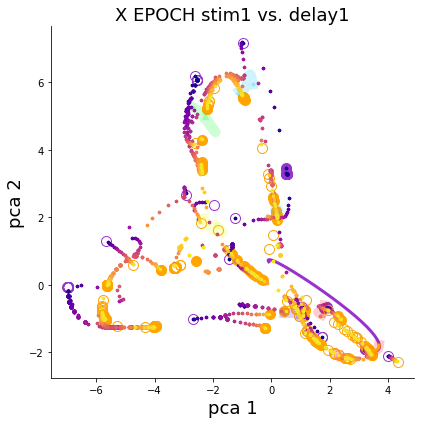

In [45]:
########## X EPOCH ###########

fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
t_set = [0,0]
trial_num = [0,0]
trial_set = range(0,80,10)
rule_set = ['delaygo',]
epoch_set = ['stim1','delay1']
step_file = 'interp_epochs'
linestyle = ['-','--']
axs ='pca'

ri = 0
rule = rule_set[ri]
epoch_axs = 0

f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch_set[epoch_axs]+'_'+str(t_set[epoch_axs])+'.0.npz')
D_use,_,_ = make_FP_axs(f,m,rule,epoch_set[epoch_axs],axs =axs, clust = 'False')
epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule_set[0])
epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule_set[0])
axes_label1 = axs + ' 1'
axes_label2 = axs + ' 2'

# use_yinds = [4,5]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]

# D_use = Beta_qr[:,use_yinds]
# D_use[:,1] = w_out[:,2]
# axes_label2 = 'sin out'

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['darkorchid','orange']

for ei in range(len(epoch_set)):
    ax = plt.subplot(111)
    
    epoch = epoch_set[ei]
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)
#     print(np.log10(qvals))
    
    stable_fp = np.log10(qvals)<-6
    plt.plot(fp_project[stable_fp==1,0],fp_project[stable_fp==1,1],'o',c = cmap_discrete[ei],
             markersize = 10, alpha = 1, linewidth = 2)
    plt.plot(fp_project[stable_fp==0,0],fp_project[stable_fp==0,1],'o',c = cmap_discrete[ei],
             markersize = 10, markerfacecolor = 'none', alpha = 1, linewidth = 2)
    
#     _,x = gen_X_from_model_dir(m,trial)
#     T_inds = get_T_inds(trial,epoch)
#     x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
#     plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 2, linestyle = linestyle[ei])
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[1])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
           linestyle = linestyle[ri], alpha = .1)
    
    plot_FP_jitter_2D(m,D_use,rule,trial_num[ei],epoch,sorted_fps,range(len(sorted_fps)),qvals,
              rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 50,
              n_jit = 1,unstable_qlim = -10,c = cmap_discrete[ei])

    for step_i in range(20):
        f = rule_set[0]+'_'+epoch_set[0]+'_'+epoch_set[1]+'_'+str(t_set[ri])+'_step_'+str(step_i)
        filename = os.path.join(m,step_file,rule_set[0],f+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']
#         print(len(step_fps))

        fp_project = np.dot(step_fps,D_use)
        plt.plot(fp_project[:,0],fp_project[:,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp))
        
tit = 'X EPOCH ' + epoch_set[0]+' vs. '+epoch_set[1]
plt.title(tit,fontsize = 18)
plt.xlabel(axes_label1,fontsize = 18)
plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [46]:
os.path.join(figpath,step_file,figname+'.pdf')

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure3/interp_epochs/pca 1_pca 2_delaygo_delay1_0_X EPOCH stim1 vs. delay1.pdf'